<a href="https://colab.research.google.com/github/Sparshj8287/ML_Journey/blob/main/06_Introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Indroduction to nlp fundamentals in tensorflow



In [1]:
#Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-05 13:14:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-05 13:14:36 (75.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
#Import functions from helper functions
from helper_functions import unzip_data, create_tensorboard_callback,plot_loss_curves,compare_historys

In [3]:
#Downloading the data
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-03-05 13:14:42--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-03-05 13:14:43 (108 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
unzip_data("nlp_getting_started.zip")

In [5]:
import pandas as pd
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
#Let shuffled the training data
train_df_shuffled=train_df.sample(frac=1,random_state=42
                                  )
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
import random
random_index = random.randint(0, len(train_df)-5) 
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Emergency Dispatchers in Boone County in the hot seat http://t.co/5fHkxtrhYU

---

Target: 1 (real disaster)
Text:
No two cases don't constitute an epidemic. http://t.co/jbLrRNMdsM  #plague #health #publichealth

---

Target: 0 (not real disaster)
Text:
Petition to remaster Fatal Frame 1 with a Windwaker-style selfie mode

---

Target: 0 (not real disaster)
Text:
SCREAMS. WHERE IS EVERYONE.

oh wait school

ok

im ok

---

Target: 1 (real disaster)
Text:
Cell Phone Shop : http://t.co/iOq051t5te #629 8-Pin Lightning Connector 2.1A Car Charger For Apple 5 5S 5C 6 6+ iÛ_ http://t.co/klxAUcNP5I

---



In [8]:
#Spilting data into train and validation dataset
from sklearn.model_selection import train_test_split
train_sentences,val_sentences,train_labels,val_labels=train_test_split(train_df_shuffled['text'].to_numpy(),train_df_shuffled['target'].to_numpy(),test_size=0.1,random_state=42)

In [9]:
len(train_sentences),len(val_sentences),len(train_labels),len(val_labels)

(6851, 762, 6851, 762)

#Converting text into numbers

In [10]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=None,
                                  standardize='lower_and_strip_punctuation',
                                  split='whitespace',
                                  ngrams=None,
                                  output_mode='int',
                                  output_sequence_length=None,
                                  )


In [11]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [12]:
max_vocal_length=10000
max_length=15
text_vectorizer=TextVectorization(max_tokens=max_vocal_length,
                                  output_mode='int',
                                  output_sequence_length=max_length)

In [13]:
text_vectorizer.adapt(train_sentences)

In [14]:
sample_sentence='There is a flood in my street'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

##Creating an Embedding using an Embedding layer


In [15]:
tf.random.set_seed(42)
from tensorflow.keras import layers
embedding=layers.Embedding(input_dim=max_vocal_length,
                           output_dim=128,
                           input_length=max_length,
                           name="embedding_1")

In [16]:
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")
sample_embed=embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
I keep scrolling to find out what he said or did....but there seems to be no exact starting point.  Wounds run deep. : /      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 2.6990976e-02, -1.1687391e-03,  2.8179400e-03, ...,
          4.8063662e-02,  1.7160047e-02, -4.1017987e-02],
        [-6.3131675e-03, -2.7558280e-02, -4.6022978e-02, ...,
         -1.6513348e-02, -1.5450157e-02,  8.7647066e-03],
        [ 7.4244663e-04, -2.6956011e-02, -3.5433352e-02, ...,
          4.1947614e-02, -2.9660761e-05, -1.9801248e-02],
        ...,
        [ 4.7172870e-02,  2.9282656e-02,  3.0252170e-02, ...,
          2.9626820e-02,  2.1589305e-02, -4.1997336e-02],
        [-1.4816761e-02,  2.2832263e-02, -3.2987848e-02, ...,
          1.6741190e-02, -3.8932491e-02,  1.3791267e-02],
        [ 3.9302651e-02,  5.2386634e-03, -1.9397512e-03, ...,
         -3.7158202e-02, -4.5223951e-02, -1.8185247e-02]]], dtype=float32)>

##Let's make the model

In [17]:
 from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), 
                    ("clf", MultinomialNB()) 
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [19]:
baseline_preds = model_0.predict(val_sentences)

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred): 
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [21]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [22]:
#Model 1:A simple dense model
from helper_functions import create_tensorboard_callback
SAVE_DIR='model_logs'

In [23]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") 
x = text_vectorizer(inputs) 
x = embedding(x) 
maxpool = tf.keras.layers.GlobalMaxPool1D() 
x=maxpool(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 


In [24]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [25]:
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
model_1_history = model_1.fit(train_sentences, 
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230305-131447
Epoch 1/5
215/215 [==============================] - 10s 36ms/step - loss: 0.6339 - accuracy: 0.6634 - val_loss: 0.5705 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.4667 - accuracy: 0.8269 - val_loss: 0.4752 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 7s 33ms/step - loss: 0.3405 - accuracy: 0.8767 - val_loss: 0.4548 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.2584 - accuracy: 0.9072 - val_loss: 0.4563 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 9s 42ms/step - loss: 0.1985 - accuracy: 0.9331 - val_loss: 0.4693 - val_accuracy: 0.7887


In [27]:
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 9ms/step - loss: 0.4693 - accuracy: 0.7887


[0.4693480134010315, 0.7887139320373535]

In [28]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.3089282 ],
       [0.806675  ],
       [0.99491453],
       [0.05105367],
       [0.19556859],
       [0.9492254 ],
       [0.91356415],
       [0.98897845],
       [0.919581  ],
       [0.09225083]], dtype=float32)

In [29]:
model_1_pred=tf.squeeze(tf.round(model_1_pred_probs))

In [30]:
model_1_results=calculate_results(y_true=val_labels,
                                  y_pred=model_1_pred)

In [31]:
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7939119079827037,
 'recall': 0.7887139107611548,
 'f1': 0.7856693843184869}

In [32]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [33]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [34]:
words_in_vocab = text_vectorizer.get_vocabulary()

In [ ]:
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

In [36]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocal_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x) 
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [37]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
model_2.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(val_sentences,val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                  "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230305-131538
Epoch 1/5
215/215 [==============================] - 20s 53ms/step - loss: 0.5087 - accuracy: 0.7456 - val_loss: 0.4559 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.3179 - accuracy: 0.8723 - val_loss: 0.5047 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 7s 31ms/step - loss: 0.2199 - accuracy: 0.9168 - val_loss: 0.5822 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 8s 36ms/step - loss: 0.1550 - accuracy: 0.9457 - val_loss: 0.6267 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 7s 31ms/step - loss: 0.1073 - accuracy: 0.9606 - val_loss: 0.8590 - val_accuracy: 0.7625


In [39]:
#Make predictions with LSTM
model_2_pred_probs=model_2.predict(val_sentences)

24/24 [==============================] - 1s 6ms/step


In [40]:
model_2_pred=tf.squeeze(tf.round(model_2_pred_probs))

In [41]:
model_2_results=calculate_results(y_true=val_labels,
                                  y_pred=model_2_pred)

In [42]:
model_2_results


{'accuracy': 76.24671916010499,
 'precision': 0.7642448462443391,
 'recall': 0.7624671916010499,
 'f1': 0.7601082692256481}

In [43]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocal_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [44]:
max_vocal_length


10000

In [45]:
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [46]:
model_3.fit(x=train_sentences,
            y=train_labels,
            validation_data=(val_sentences,val_labels),
            epochs=5,
            callbacks=[create_tensorboard_callback(SAVE_DIR,'GRU')])

Saving TensorBoard log files to: model_logs/GRU/20230305-131629
Epoch 1/5
215/215 [==============================] - 12s 35ms/step - loss: 0.5305 - accuracy: 0.7235 - val_loss: 0.4543 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.3200 - accuracy: 0.8676 - val_loss: 0.4886 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 9s 44ms/step - loss: 0.2149 - accuracy: 0.9194 - val_loss: 0.5549 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 16s 74ms/step - loss: 0.1505 - accuracy: 0.9477 - val_loss: 0.6213 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 11s 53ms/step - loss: 0.1102 - accuracy: 0.9616 - val_loss: 0.6295 - val_accuracy: 0.7664


In [47]:
#Let predict the results
model_3_pred_probs=model_3.predict(val_sentences)
model_3_pred=tf.squeeze(tf.round(model_3_pred_probs))
model_3_results=calculate_results(y_true=val_labels,
                                  y_pred=model_3_pred)

24/24 [==============================] - 2s 8ms/step


In [48]:
model_3_results


{'accuracy': 76.64041994750657,
 'precision': 0.7660697359722247,
 'recall': 0.7664041994750657,
 'f1': 0.7657033077547232}

In [49]:
baseline_results


{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [50]:
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocal_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

inputs=layers.Input(shape=(1,),dtype='string')
x=text_vectorizer(inputs)
x=model_4_embedding(x)
x=layers.Bidirectional(layers.LSTM(64))(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
model_4=tf.keras.Model(inputs,outputs,name='model_4_Bidirectional')

In [51]:
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [52]:
model_4.fit(x=train_sentences,
            y=train_labels,
            validation_data=(val_sentences,val_labels),
            epochs=5,
            callbacks=[create_tensorboard_callback(SAVE_DIR,'Bidirectional')])

Saving TensorBoard log files to: model_logs/Bidirectional/20230305-131730
Epoch 1/5
215/215 [==============================] - 28s 69ms/step - loss: 0.5091 - accuracy: 0.7444 - val_loss: 0.4587 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 12s 55ms/step - loss: 0.3140 - accuracy: 0.8707 - val_loss: 0.5135 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 13s 60ms/step - loss: 0.2127 - accuracy: 0.9184 - val_loss: 0.5701 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 13s 58ms/step - loss: 0.1456 - accuracy: 0.9507 - val_loss: 0.6779 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 12s 55ms/step - loss: 0.1025 - accuracy: 0.9645 - val_loss: 0.6764 - val_accuracy: 0.7612


In [53]:
model_4_pred_probs=model_3.predict(val_sentences)
model_4_pred=tf.squeeze(tf.round(model_4_pred_probs))
model_4_results=calculate_results(y_true=val_labels,
                                  y_pred=model_4_pred)

24/24 [==============================] - 0s 8ms/step


In [54]:
model_4_results


{'accuracy': 76.64041994750657,
 'precision': 0.7660697359722247,
 'recall': 0.7664041994750657,
 'f1': 0.7657033077547232}

In [55]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [56]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocal_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, padding='same',activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 15, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [57]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230305-131906
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.5624 - accuracy: 0.7225 - val_loss: 0.4704 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3407 - accuracy: 0.8618 - val_loss: 0.4637 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2128 - accuracy: 0.9219 - val_loss: 0.5143 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1340 - accuracy: 0.9577 - val_loss: 0.5949 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0942 - accuracy: 0.9685 - val_loss: 0.6330 - val_accuracy: 0.7848


In [58]:
model_5_pred_probs=model_5.predict(val_sentences)
model_5_pred=tf.squeeze(tf.round(model_5_pred_probs))

24/24 [==============================] - 0s 3ms/step


In [59]:
model_5_results=calculate_results(y_true=val_labels,
                                  y_pred=model_5_pred)

In [60]:
model_5_results


{'accuracy': 78.4776902887139,
 'precision': 0.7864921992772048,
 'recall': 0.7847769028871391,
 'f1': 0.7829447143669434}

In [61]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [62]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples.shape)

(2, 512)


In [65]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], 
                                        dtype=tf.string, 
                                        trainable=False, 
                                        name="USE") 

In [66]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, 
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")


model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [67]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230305-132131
Epoch 1/5
215/215 [==============================] - 7s 15ms/step - loss: 0.5023 - accuracy: 0.7886 - val_loss: 0.4506 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4154 - accuracy: 0.8135 - val_loss: 0.4395 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4011 - accuracy: 0.8199 - val_loss: 0.4348 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3941 - accuracy: 0.8251 - val_loss: 0.4295 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3880 - accuracy: 0.8285 - val_loss: 0.4308 - val_accuracy: 0.8136


In [68]:
model_6_pred_probs = model_6.predict(val_sentences)

24/24 [==============================] - 1s 11ms/step


In [69]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [70]:
model_6_results = calculate_results(val_labels, model_6_preds)

In [71]:
model_6_results

{'accuracy': 81.36482939632546,
 'precision': 0.8160661319598898,
 'recall': 0.8136482939632546,
 'f1': 0.8120618868299143}

In [72]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [78]:
#train_10_percent=train_df_shuffled[['text','target']].sample(frac=0.1,random_state=42)
#train_10_percent_sentence=train_10_percent["text"].to_list()
#train_10_percent_label=train_10_percent['target'].to_list()
#len(train_10_percent_sentence),len(train_10_percent_label)

(761, 761)

In [84]:
len_10_percent=int(0.1*len(train_sentences))
train_10_percent_sentence=train_sentences[:len_10_percent]
train_10_percent_label=train_labels[:len_10_percent]

In [85]:
len(val_sentences)

762

In [86]:
model_7=tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')
],name='10_percent')
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_7.summary()
    


Model: "10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [87]:
history_10_percent=model_7.fit(x=train_10_percent_sentence,
                               y=train_10_percent_label,
                               validation_data=(val_sentences,val_labels),
                               epochs=5,
                               callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                      '10_percent')])

Saving TensorBoard log files to: model_logs/10_percent/20230305-135413
Epoch 1/5
22/22 [==============================] - 3s 59ms/step - loss: 0.6672 - accuracy: 0.6964 - val_loss: 0.6439 - val_accuracy: 0.7520
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5963 - accuracy: 0.8131 - val_loss: 0.5863 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5221 - accuracy: 0.8190 - val_loss: 0.5329 - val_accuracy: 0.7677
Epoch 4/5
22/22 [==============================] - 1s 44ms/step - loss: 0.4624 - accuracy: 0.8263 - val_loss: 0.5029 - val_accuracy: 0.7808
Epoch 5/5
22/22 [==============================] - 1s 57ms/step - loss: 0.4209 - accuracy: 0.8336 - val_loss: 0.4871 - val_accuracy: 0.7822


In [88]:
model_7_pred_probs = model_7.predict(val_sentences)

24/24 [==============================] - 1s 20ms/step


In [89]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

In [90]:
model_7_results = calculate_results(val_labels, model_7_preds)

In [91]:
model_7_results

{'accuracy': 78.21522309711287,
 'precision': 0.7838036599424153,
 'recall': 0.7821522309711286,
 'f1': 0.7802976986884913}

In [92]:
model_6_results

{'accuracy': 81.36482939632546,
 'precision': 0.8160661319598898,
 'recall': 0.8136482939632546,
 'f1': 0.8120618868299143}

In [101]:
all_model_results=pd.DataFrame({"0_baseline_results":baseline_results,
                               "1_model_1_results":model_1_results,
                               "2_model_2_results":model_2_results,
                               "3_model_3_results":model_3_results,
                               "4_model_4_results":model_4_results,
                               "5_model_5_results":model_5_results,
                               "6_model_6_results":model_6_results,
                               "7_model_7_results":model_7_results,})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline_results,79.265092,0.811139,0.792651,0.786219
1_model_1_results,78.871391,0.793912,0.788714,0.785669
2_model_2_results,76.246719,0.764245,0.762467,0.760108
3_model_3_results,76.640420,0.766070,0.766404,0.765703
4_model_4_results,76.640420,0.766070,0.766404,0.765703
5_model_5_results,78.477690,0.786492,0.784777,0.782945
6_model_6_results,81.364829,0.816066,0.813648,0.812062
7_model_7_results,78.215223,0.783804,0.782152,0.780298


In [102]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

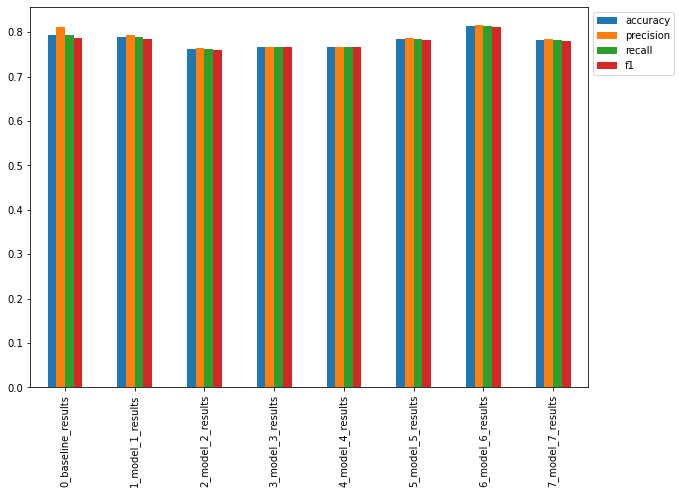

In [103]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

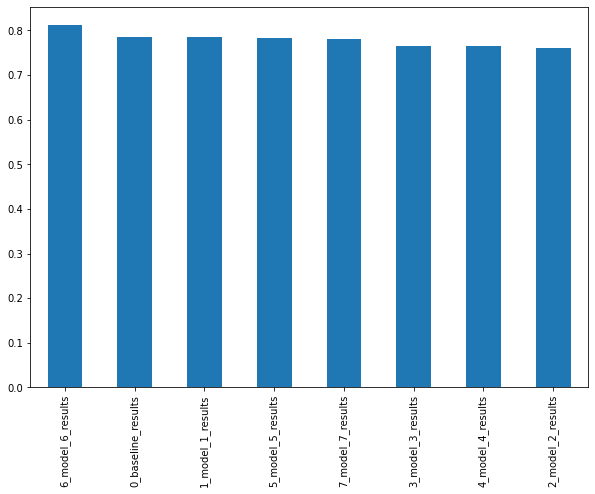

In [104]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


In [105]:
!tensorboard dev upload --logdir ./model_logs \
--name "NLP modelling experiments" \
--description "A series of different NLP modellings experiments with various models" \
--one_shot 

2023-03-05 14:15:04.071630: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-05 14:15:04.071918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-05 14:15:04.071945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-05 14:15:07.986610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to c

In [106]:
model_6.save("model_6.h5")

In [107]:
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [108]:
model_6.save("model_6_SavedModel_format")

In [109]:
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [110]:
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 13ms/step - loss: 0.4308 - accuracy: 0.8136


[0.4308437705039978, 0.8136482834815979]

In [ ]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

In [112]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.918913
759,FedEx will no longer transport bioterror patho...,0,1.0,0.861760
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.853777
628,@noah_anyname That's where the concentration c...,0,1.0,0.827602
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.825800
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.800720
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.798293
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.793224
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.785769
695,A look at state actions a year after Ferguson'...,0,1.0,0.751021


In [113]:
for row in most_wrong[:10].itertuples(): 
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9189128279685974
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8617600798606873
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.853777289390564
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8276022672653198
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8257996439933777
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8007203340530396
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1, Pr

In [114]:
def predict_on_sentence(model, sentence):
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [115]:
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [116]:
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 100ms/step
Pred: 1.0 (real disaster) Prob: 0.9557433724403381
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [117]:
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 92ms/step
Pred: 1.0 (real disaster) Prob: 0.9642820358276367
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon
